# Short Term Risk Prediction With XGBoost

In this notebook, we perform the same training as in V3, however, I will perform 3-fold cross validation correctly without leaking the test set to get accurate measurements for recall.

In [1]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import scikitplot as skplt
import time
import pickle

os.environ["OMP_NUM_THREADS"] = "8"

TRAIN = True

## Training With The V1 Data

In [7]:
v1_data = pd.read_csv("Clean_Data_LogReg.csv")

In [3]:
v1_data.shape

(67023, 120)

In [4]:
v1_data.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,...,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_22,admission_source_id_25
0,10,3,59,0,18,0,0,0,9,-200,...,0,1,0,0,0,0,0,0,0,0
1,20,2,11,5,13,2,0,1,6,-200,...,0,1,0,0,0,0,0,0,0,0
2,30,2,44,1,16,0,0,0,7,-200,...,0,1,0,0,0,0,0,0,0,0
3,40,1,51,0,8,0,0,0,5,-200,...,0,1,0,0,0,0,0,0,0,0
4,50,3,31,6,16,0,0,0,9,-200,...,0,0,0,0,0,0,0,0,0,0


# Train Test Split

In [8]:
X_v1 = v1_data.drop(['readmitted','within30'],axis=1)
y_v1 = v1_data['within30']


Examples in training:

In [9]:
y_v1.value_counts()

0    63859
1     3164
Name: within30, dtype: int64

Examples in testing:

In both cases, the proportion of classes in the same.

In [10]:
scale_pos_weight = y_v1.value_counts()[0] / y_v1.value_counts()[1]
scale_pos_weight


20.18299620733249

This is our baseline for the scale_pos_weight parameter.

## Use Stratified K-Fold Evaluation With Hyperparameter Search

In [22]:
def compute_precision(tp, fp):
    return tp / (tp + fp)

def compute_recall(tp, fn):
    return tp / (tp + fn)


In [27]:
accuracies = np.array([])
precisions = np.array([])
recalls = np.array([])
roc_aucs = np.array([])

param_grid = {
    'max_depth': [3, 6, 8],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.3, 0.1, 0.03],
    'min_child_weight': [1, 3, 5]
}

v1_model = XGBClassifier(n_jobs=8, scale_pos_weight=scale_pos_weight)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

for train_index, test_index in skf.split(X_v1, y_v1):
    x_train = X_v1.loc[train_index, :]
    y_train = y_v1[train_index]
    x_test = X_v1.loc[test_index, :]
    y_test = y_v1[test_index]
    # We do another stratified 2-fold split to make a training and test set.
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
    grid_search = GridSearchCV(v1_model, param_grid, scoring="recall", n_jobs=8, cv=kfold)
    grid_result = grid_search.fit(x_train, y_train)
    
    # Now that we have found hyperparameters we compute the evaluation metrics on our test data
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    best_model = grid_result.best_estimator_
    y_pred = best_model.predict(x_test)
    y_pred_proba = best_model.predict_proba(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = compute_precision(tp, fp)
    recall = compute_recall(tp, fn)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    np.append(accuracies, accuracy)
    np.append(precisions, precision)
    np.append(recalls, recall)
    np.append(roc_aucs, auc)
    

KeyboardInterrupt: 

In [ ]:
print("Accuracy: Mean: %f, SD: %f" % np.mean(accuracies), np.std(accuracies))
print("Precision: Mean: %f, SD: %f" % np.mean(precisions), np.std(precisions))
print("Recall: Mean: %f, SD: %f" % np.mean(recalls), np.std(recalls))
print("ROC AUC: Mean: %f, SD: %f" % np.mean(roc_aucs), np.std(roc_aucs))

## Training With The V2 Data

In [ ]:
v2_data = pd.read_csv("Clean_Data_v2.csv")

In [ ]:
v2_data.shape

In [ ]:
v2_data.head()

In [ ]:
X_v2 = v2_data.drop(['readmitted','within30'],axis=1)
y_v2 = v2_data['within30']


In [ ]:
accuracies_v2 = np.array([])
precisions_v2 = np.array([])
recalls_v2 = np.array([])
roc_aucs_v2 = np.array([])

param_grid = {
    'max_depth': [3, 6, 8],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.3, 0.1, 0.03],
    'min_child_weight': [1, 3, 5]
}

v2_model = XGBClassifier(n_jobs=8, scale_pos_weight=scale_pos_weight)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)

for train_index, test_index in skf.split(X_v2, y_v2):
    x_train = X_v2.loc[train_index, :]
    y_train = y_v2[train_index]
    x_test = X_v2.loc[test_index, :]
    y_test = y_v2[test_index]
    # We do another stratified 2-fold split to make a training and test set.
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
    grid_search = GridSearchCV(v1_model, param_grid, scoring="recall", n_jobs=8, cv=kfold)
    grid_result = grid_search.fit(x_train, y_train)
    
    # Now that we have found hyperparameters we compute the evaluation metrics on our test data
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    best_model = grid_result.best_estimator_
    y_pred = best_model.predict(x_test)
    y_pred_proba = best_model.predict_proba(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = compute_precision(tp, fp)
    recall = compute_recall(tp, fn)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    np.append(accuracies, accuracy)
    np.append(precisions, precision)
    np.append(recalls, recall)
    np.append(roc_aucs, auc)

# Dealing With Class Imbalance

## Grid Search For Hyperparameters

Note that we are not using classification error for the evaluation metric because we would get "good" results from just choosing the negative class all the time. Instead, we use the auc curve so we need to perform well on the positive and negative cases.

Given that we are having issues with recall, we will change the scoring parameter to recall as opposed to ROC AUC as well.

In [64]:
model = XGBClassifier(n_jobs=8, scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [3, 6, 8, 12],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.3, 0.1, 0.03],
    'min_child_weight': [1, 3, 5]
}

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
grid_search = GridSearchCV(model, param_grid, scoring="recall", n_jobs=8, cv=kfold)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.615385 using {'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}


## Train A Model With Best Hyperparameters

In [65]:
model = XGBClassifier(n_jobs=8, learning_rate=0.03, max_depth=3, n_estimators=100, scale_pos_weight=scale_pos_weight, min_child_weight=3)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)

## Tune Subsampling Parameters

XGBoost also has a lot of hyperparameters related to subsampling rows and columns when constructing trees. This can help generalizability. Ideally, we would have used variants of these in the grid search above but that would have required us to train exponentially more models. We don't think the subsampling parameters interact similar to learning rate, number of trees, and tree size do so we think we should be able to perform a grid search on the subsampling parameters with the other hyperparameters fixed to their optimums found above. We should end up with parameter settings similar to what would have been found if we had trained all possible permuations. We are trying to save computation by not training models with suboptimal settings for the parameters tested in the previous step.

In [76]:
model2 = XGBClassifier(n_jobs=8, learning_rate=0.03, max_depth=3, n_estimators=100, scale_pos_weight=scale_pos_weight, min_child_weight=3)
param_grid2 = {
    'colsample_bylevel': [0.5, 0.75, 1],
    'colsample_bynode': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'subsample': [0.5, 0.75, 1],
}

grid_search = GridSearchCV(model2, param_grid2, scoring="recall", n_jobs=8, cv=kfold)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.638958 using {'colsample_bylevel': 0.75, 'colsample_bynode': 0.75, 'colsample_bytree': 0.75, 'subsample': 0.75}


## Train the Model With All Best Parameters

In [101]:
model2 = XGBClassifier(n_jobs=8, learning_rate=0.03, max_depth=3, n_estimators=100, scale_pos_weight=scale_pos_weight, min_child_weight=3, colsample_bylevel=0.75, colsample_bynode=0.75, colsample_bytree=0.75, subsample=0.75)
model2.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
              colsample_bynode=0.75, colsample_bytree=0.75, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20.6794208893485,
              seed=None, silent=None, subsample=0.75, verbosity=1)

## Accuracy

In [102]:
y_train_pred = model2.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 69.19%


In [103]:
# make predictions for test set
y_pred = model2.predict(X_test)
y_pred_proba = model2.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.13%


In [104]:
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [105]:
np.sum(y_pred)

6698

In [106]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  13896
False Positives:  6101
False Negatives:  370
True Positives:  597


In [107]:
def compute_precision(tp, fp):
    return tp / (tp + fp)

def compute_recall(tp, fn):
    return tp / (tp + fn)

precision = compute_precision(tp, fp)
recall = compute_recall(tp, fn)

print('Precision: {0:.2f}\n\nRecall: {1:.2f}'.format(precision, recall))

Precision: 0.09

Recall: 0.62


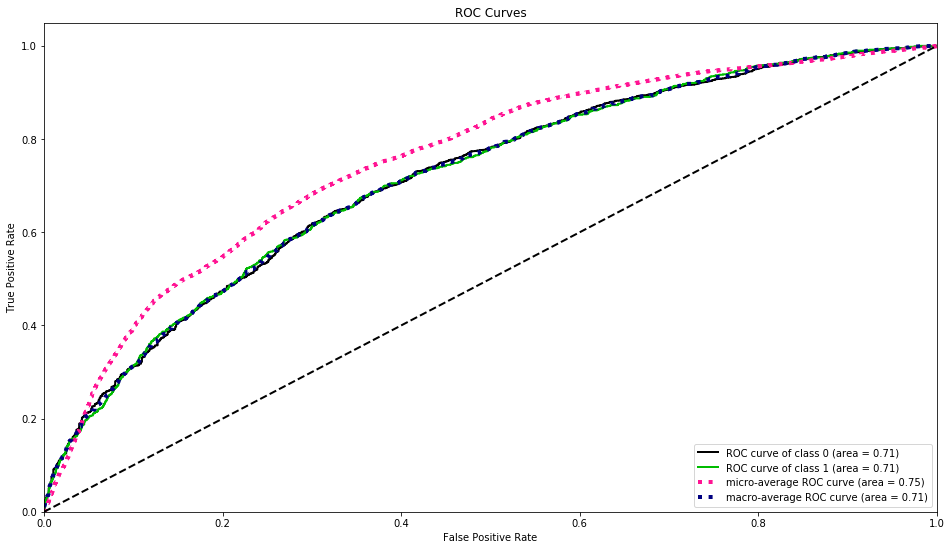

In [108]:
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()


We finally have a model that has good recall and the AUC is still 0.72 which is around the previous optimum found by other models that had bad recall.

## Serialize model

In [109]:
pickle.dump(model2, open("short_term_xgboost_v3.pickle.dat", "wb"))

## Feature Importance

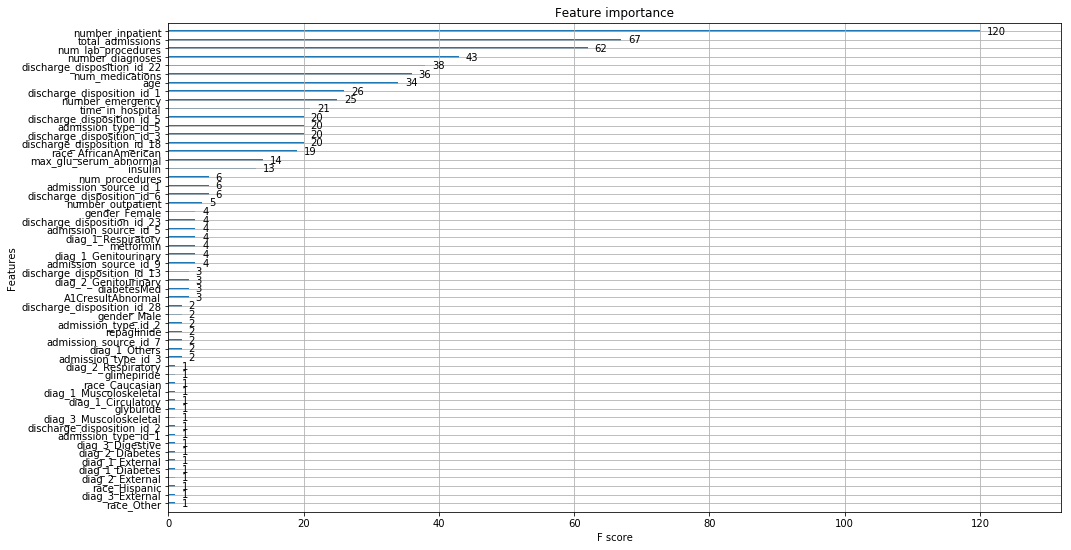

In [110]:
plt.rcParams["figure.figsize"] = [16,9]
plot_importance(model2)
plt.show()

There are a lot of features here but we can limit the number of features because it appears that only the top few are important.

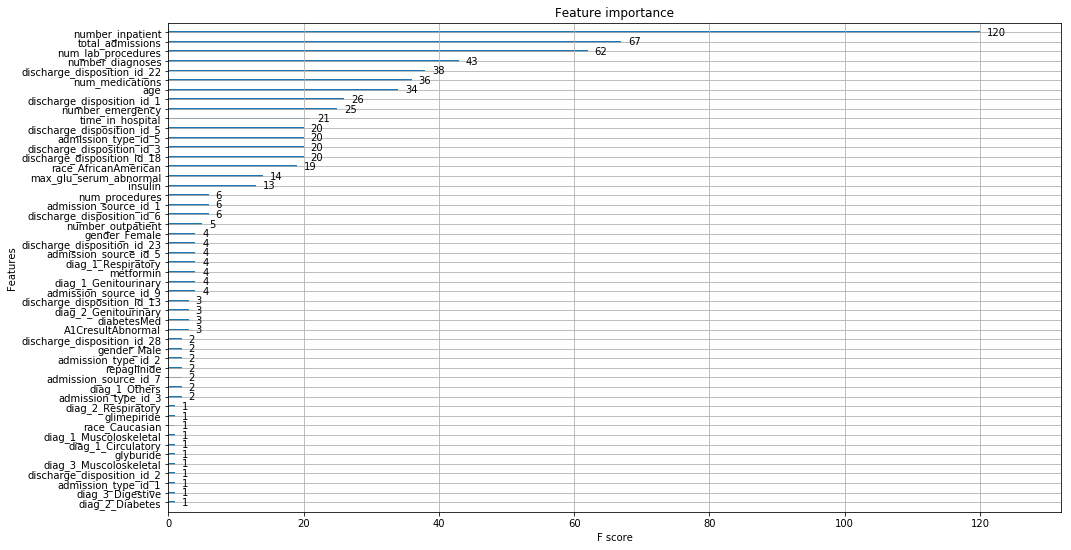

In [111]:
plot_importance(model2, max_num_features=50)
plt.show()
